# EVAOnline Validation - Complete Workflow Example

This notebook demonstrates the complete EVAOnline validation workflow:

1. **Load raw climate data** from NASA POWER and Open-Meteo
2. **Calculate descriptive statistics** for each dataset
3. **Calculate ETo** using EVAOnline FAO-56 Penman-Monteith algorithm
4. **Validate** against reference data (Open-Meteo official ETo and Xavier BR-DWGD)
5. **Compare** all ETo sources with comprehensive metrics

**Example city**: Piracicaba, SP (23.7°S, 47.6°W, 546m elevation)
**Period**: 1991-2020 (30 years)

## 1. Setup and Import Libraries

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 150

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Pandas version: 2.3.3
NumPy version: 2.3.5


In [4]:
# Define paths and city
city_name = "Piracicaba_SP"
data_dir = Path("../data")
original_data_dir = data_dir / "original_data"

# City metadata
city_info = {
    "name": "Piracicaba",
    "state": "São Paulo",
    "lat": -22.7,
    "lon": -47.6,
    "elevation": 546  # meters
}

print(f"Configuration:")
print(f"  City: {city_info['name']}, {city_info['state']}")
print(f"  Coordinates: {city_info['lat']:.2f}°, {city_info['lon']:.2f}°")
print(f"  Elevation: {city_info['elevation']} m")
print(f"  Period: 1991-2020 (30 years)")
print(f"\nData directory: {data_dir.absolute()}")

Configuration:
  City: Piracicaba, São Paulo
  Coordinates: -22.70°, -47.60°
  Elevation: 546 m
  Period: 1991-2020 (30 years)

Data directory: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\notebooks\..\data


## 2. Load Raw Climate Data

In [5]:
# Load NASA POWER raw data
nasa_file = original_data_dir / "nasa_power_raw" / f"{city_name}_1991-01-01_2020-12-31_NASA_RAW.csv"
df_nasa = pd.read_csv(nasa_file, parse_dates=['date'])

print("NASA POWER Raw Data:")
print(f"  Records: {len(df_nasa):,}")
print(f"  Period: {df_nasa['date'].min()} to {df_nasa['date'].max()}")
print(f"  Variables: {', '.join(df_nasa.columns.drop('date').tolist())}")
print(f"\n{df_nasa.head()}")

# Load Open-Meteo raw data
openmeteo_file = original_data_dir / "open_meteo_raw" / f"{city_name}_1991-01-01_2020-12-31_OpenMeteo_RAW.csv"
df_openmeteo = pd.read_csv(openmeteo_file, parse_dates=['date'])

print("\n" + "="*80)
print("Open-Meteo Raw Data (ERA5-Land):")
print(f"  Records: {len(df_openmeteo):,}")
print(f"  Period: {df_openmeteo['date'].min()} to {df_openmeteo['date'].max()}")
print(f"  Variables: {', '.join(df_openmeteo.columns.drop('date').tolist())}")
print(f"\n{df_openmeteo.head()}")

NASA POWER Raw Data:
  Records: 10,958
  Period: 1991-01-01 00:00:00 to 2020-12-31 00:00:00
  Variables: T2M_MAX, T2M_MIN, T2M, RH2M, WS2M, ALLSKY_SFC_SW_DWN, PRECTOTCORR

        date  T2M_MAX  T2M_MIN    T2M   RH2M  WS2M  ALLSKY_SFC_SW_DWN  \
0 1991-01-01    30.04    17.52  23.38  60.93  1.99              24.77   
1 1991-01-02    32.42    16.45  24.60  64.43  1.93              23.66   
2 1991-01-03    29.39    19.95  23.76  79.21  2.17              14.69   
3 1991-01-04    26.56    18.70  22.48  80.44  1.78              12.90   
4 1991-01-05    25.87    17.65  21.15  76.98  3.30              24.51   

   PRECTOTCORR  
0         0.56  
1         1.01  
2        12.70  
3        13.57  
4         0.25  

Open-Meteo Raw Data (ERA5-Land):
  Records: 10,958
  Period: 1991-01-01 00:00:00 to 2020-12-31 00:00:00
  Variables: T2M_MAX, T2M_MIN, T2M, RH2M, WS10M, ALLSKY_SFC_SW_DWN, PRECTOTCORR

        date  T2M_MAX  T2M_MIN   T2M  RH2M  WS10M  ALLSKY_SFC_SW_DWN  \
0 1991-01-01     28.4     17.

## 3. Descriptive Statistics of Raw Data

Descriptive Statistics - NASA POWER:
                                  mean        std                  min  \
date               2005-12-31 12:00:00        NaN  1991-01-01 00:00:00   
T2M_MAX                       27.94229    3.51792                13.29   
T2M_MIN                      16.072515   3.635726                 0.23   
T2M                          21.472837   3.269817                 7.28   
RH2M                         74.893731  10.843808                26.35   
WS2M                          2.034403   0.790252                 0.54   
ALLSKY_SFC_SW_DWN            18.432995   5.809834                  1.2   
PRECTOTCORR                   3.659418   6.928951                  0.0   

                                   max  
date               2020-12-31 00:00:00  
T2M_MAX                          42.03  
T2M_MIN                          25.48  
T2M                              32.78  
RH2M                             96.23  
WS2M                              6.26  
ALLSKY_SF

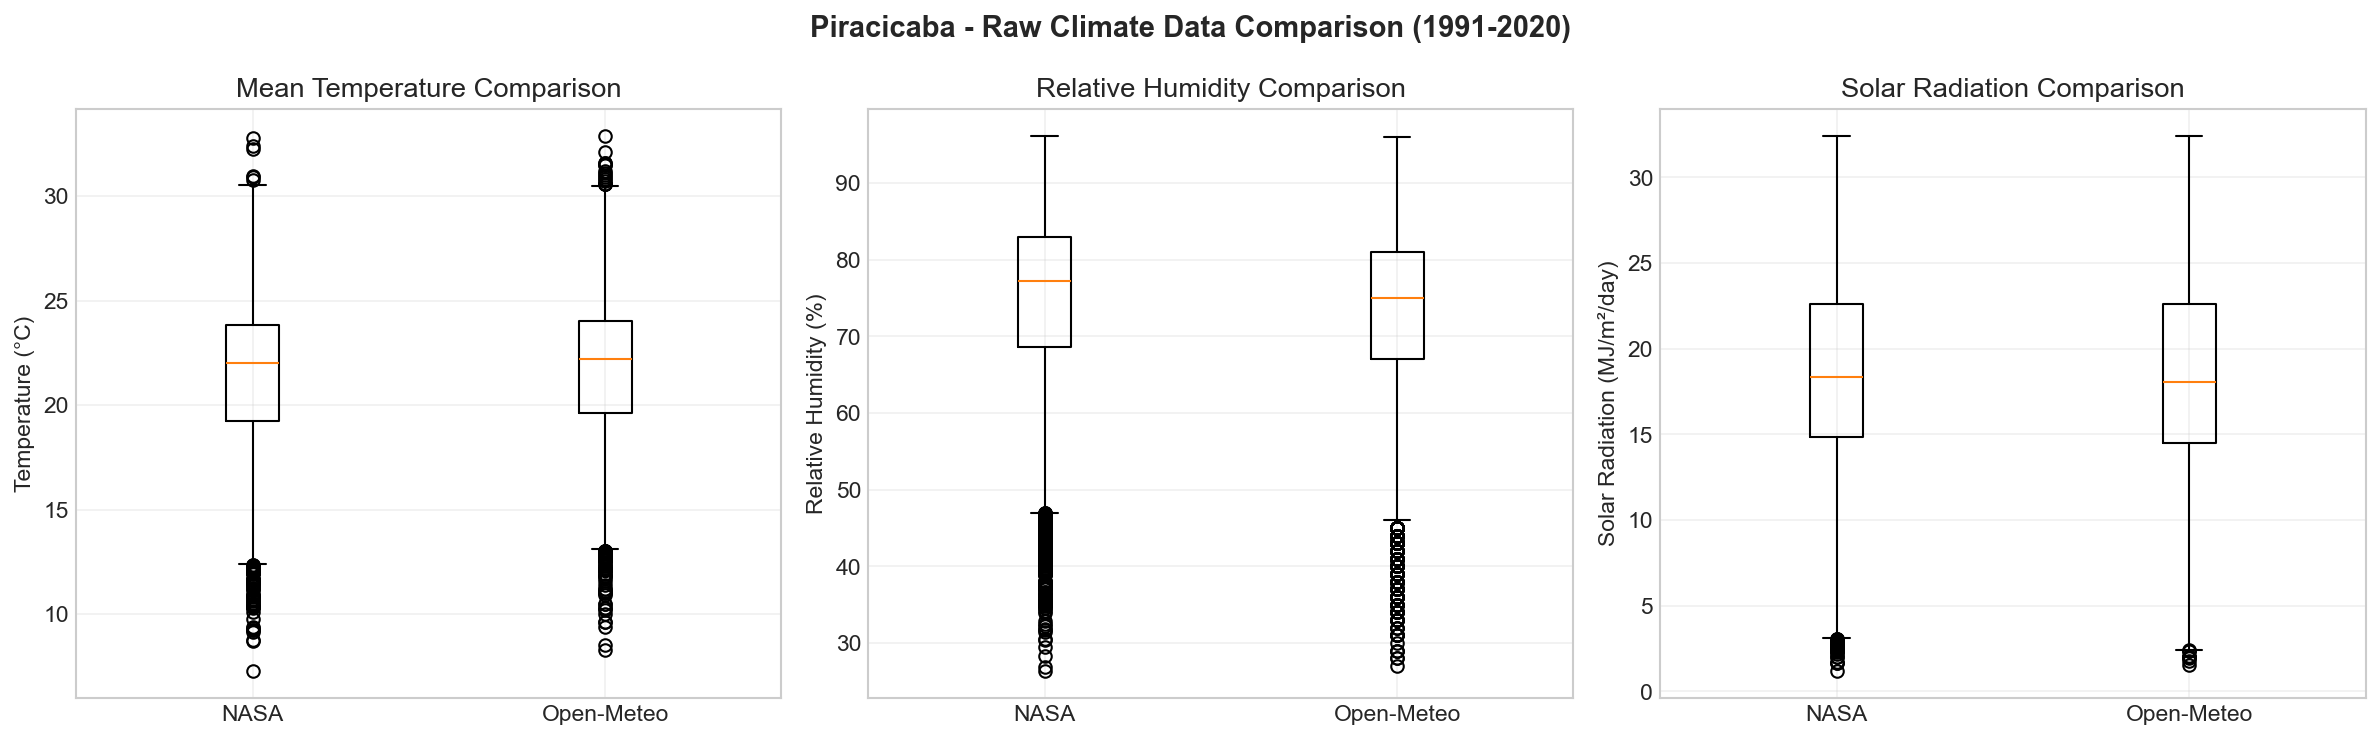

In [6]:
# Calculate descriptive statistics for NASA POWER
nasa_stats = df_nasa.describe().T
nasa_stats['source'] = 'NASA POWER'

# Calculate descriptive statistics for Open-Meteo
openmeteo_stats = df_openmeteo.describe().T
openmeteo_stats['source'] = 'Open-Meteo'

# Combine and display
print("Descriptive Statistics - NASA POWER:")
print(nasa_stats[['mean', 'std', 'min', 'max']].round(2))

print("\n" + "="*80)
print("Descriptive Statistics - Open-Meteo:")
print(openmeteo_stats[['mean', 'std', 'min', 'max']].round(2))

# Compare temperature statistics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Temperature comparison
axes[0].boxplot([df_nasa['T2M'], df_openmeteo['T2M']], labels=['NASA', 'Open-Meteo'])
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Mean Temperature Comparison')
axes[0].grid(True, alpha=0.3)

# Relative humidity comparison
axes[1].boxplot([df_nasa['RH2M'], df_openmeteo['RH2M']], labels=['NASA', 'Open-Meteo'])
axes[1].set_ylabel('Relative Humidity (%)')
axes[1].set_title('Relative Humidity Comparison')
axes[1].grid(True, alpha=0.3)

# Solar radiation comparison
axes[2].boxplot([df_nasa['ALLSKY_SFC_SW_DWN'], df_openmeteo['ALLSKY_SFC_SW_DWN']], 
                labels=['NASA', 'Open-Meteo'])
axes[2].set_ylabel('Solar Radiation (MJ/m²/day)')
axes[2].set_title('Solar Radiation Comparison')
axes[2].grid(True, alpha=0.3)

plt.suptitle(f'{city_info["name"]} - Raw Climate Data Comparison (1991-2020)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Calculate ETo Using EVAOnline Algorithm (FAO-56 Penman-Monteith)

In [7]:
class EToFAO56:
    """FAO-56 Penman-Monteith ETo calculation (Allen et al., 1998)"""
    
    Gsc = 0.0820  # Solar constant [MJ m⁻² min⁻¹]
    sigma = 4.903e-9  # Stefan-Boltzmann [MJ K⁻⁴ m⁻² day⁻¹]
    albedo = 0.23  # Reference grass albedo

    @staticmethod
    def fractional_day_of_year(date_str: str) -> float:
        """Convert date to fractional day of year (1-365/366)"""
        dt = pd.to_datetime(date_str)
        day_of_year = dt.dayofyear
        return day_of_year

    @staticmethod
    def atmospheric_pressure(elevation: float) -> float:
        """Calculate atmospheric pressure (kPa) from elevation (m)"""
        return 101.3 * ((293 - 0.0065 * elevation) / 293) ** 5.26

    @staticmethod
    def psychrometric_constant(elevation: float) -> float:
        """Calculate psychrometric constant γ (kPa/°C)"""
        P = EToFAO56.atmospheric_pressure(elevation)
        return 0.000665 * P

    @staticmethod
    def wind_speed_2m(u_height: np.ndarray, height: float = 10.0) -> np.ndarray:
        """Convert wind speed from height z to 2m using FAO-56 Eq. 47"""
        if height == 2.0:
            return np.maximum(u_height, 0.5)
        factor = 4.87 / np.log(67.8 * height - 5.42)
        u2 = u_height * factor
        return np.maximum(u2, 0.5)

    @staticmethod
    def extraterrestrial_radiation(lat: float, doy: np.ndarray) -> np.ndarray:
        """Calculate extraterrestrial radiation Ra (MJ/m²/day)"""
        lat_rad = np.deg2rad(lat)
        dr = 1 + 0.033 * np.cos(2 * np.pi * doy / 365)
        delta = 0.409 * np.sin(2 * np.pi * doy / 365 - 1.39)
        ws = np.arccos(-np.tan(lat_rad) * np.tan(delta))
        Ra = (24 * 60 / np.pi) * EToFAO56.Gsc * dr * (
            ws * np.sin(lat_rad) * np.sin(delta) +
            np.cos(lat_rad) * np.cos(delta) * np.sin(ws)
        )
        return Ra

    @staticmethod
    def clear_sky_radiation(Ra: np.ndarray, elevation: float) -> np.ndarray:
        """Calculate clear-sky radiation Rso (MJ/m²/day)"""
        return (0.75 + 2e-5 * elevation) * Ra

    @staticmethod
    def net_longwave_radiation(
        Rs: np.ndarray, Ra: np.ndarray, Tmax: np.ndarray, 
        Tmin: np.ndarray, ea: np.ndarray, elevation: float
    ) -> np.ndarray:
        """Calculate net longwave radiation Rnl (MJ/m²/day)"""
        Rso = EToFAO56.clear_sky_radiation(Ra, elevation)
        Tmax_K = Tmax + 273.16
        Tmin_K = Tmin + 273.16
        
        with np.errstate(divide='ignore', invalid='ignore'):
            Rs_Rso = np.where(Rso > 0, Rs / Rso, 0)
            Rs_Rso = np.clip(Rs_Rso, 0.3, 1.0)
        
        Rnl = EToFAO56.sigma * (
            (Tmax_K**4 + Tmin_K**4) / 2 *
            (0.34 - 0.14 * np.sqrt(ea)) *
            (1.35 * Rs_Rso - 0.35)
        )
        return Rnl

    @staticmethod
    def calculate_et0(df: pd.DataFrame, lat: float, elevation: float, 
                     wind_height: float = 10.0) -> pd.Series:
        """
        Calculate reference evapotranspiration ETo (mm/day) using FAO-56 Penman-Monteith
        
        Args:
            df: DataFrame with columns [T2M_MAX, T2M_MIN, T2M, RH2M, WS2M or WS10M, ALLSKY_SFC_SW_DWN]
            lat: Latitude (decimal degrees)
            elevation: Elevation (meters)
            wind_height: Wind measurement height (2m for NASA, 10m for Open-Meteo)
        
        Returns:
            Series with ETo values (mm/day)
        """
        # Extract variables
        Tmax = df['T2M_MAX'].values
        Tmin = df['T2M_MIN'].values
        Tmean = df['T2M'].values
        RH = df['RH2M'].values
        
        # Wind speed - detect column name
        wind_col = 'WS2M' if 'WS2M' in df.columns else 'WS10M'
        u_z = df[wind_col].values
        
        Rs = df['ALLSKY_SFC_SW_DWN'].values
        
        # Day of year
        doy = df['date'].apply(EToFAO56.fractional_day_of_year).values
        
        # Constants
        gamma = EToFAO56.psychrometric_constant(elevation)
        
        # Saturation vapor pressure (kPa)
        es_max = 0.6108 * np.exp(17.27 * Tmax / (Tmax + 237.3))
        es_min = 0.6108 * np.exp(17.27 * Tmin / (Tmin + 237.3))
        es = (es_max + es_min) / 2
        
        # Actual vapor pressure (kPa)
        ea = es * (RH / 100)
        
        # Slope of saturation vapor pressure curve (kPa/°C)
        Delta = 4098 * (0.6108 * np.exp(17.27 * Tmean / (Tmean + 237.3))) / ((Tmean + 237.3) ** 2)
        
        # Wind speed at 2m
        u2 = EToFAO56.wind_speed_2m(u_z, wind_height)
        
        # Radiation calculations
        Ra = EToFAO56.extraterrestrial_radiation(lat, doy)
        Rns = (1 - EToFAO56.albedo) * Rs  # Net shortwave radiation
        Rnl = EToFAO56.net_longwave_radiation(Rs, Ra, Tmax, Tmin, ea, elevation)
        Rn = Rns - Rnl  # Net radiation
        
        # Soil heat flux (G ≈ 0 for daily calculations)
        G = 0
        
        # FAO-56 Penman-Monteith equation
        numerator = 0.408 * Delta * (Rn - G) + gamma * (900 / (Tmean + 273)) * u2 * (es - ea)
        denominator = Delta + gamma * (1 + 0.34 * u2)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            ET0 = np.where(denominator != 0, numerator / denominator, np.nan)
        
        # Physical constraints
        ET0 = np.clip(ET0, 0, 20)  # 0-20 mm/day
        
        return pd.Series(ET0, index=df.index)

print("EVAOnline FAO-56 Penman-Monteith class defined successfully!")

EVAOnline FAO-56 Penman-Monteith class defined successfully!


In [8]:
# Calculate ETo for NASA POWER data (wind at 2m)
print("Calculating ETo from NASA POWER data...")
df_nasa['eto_nasa_calculated'] = EToFAO56.calculate_et0(
    df_nasa, 
    lat=city_info['lat'], 
    elevation=city_info['elevation'],
    wind_height=2.0  # NASA POWER wind at 2m
)

print(f"  Valid ETo records: {df_nasa['eto_nasa_calculated'].notna().sum():,}/{len(df_nasa):,}")
print(f"  Mean ETo: {df_nasa['eto_nasa_calculated'].mean():.3f} mm/day")
print(f"  Std: {df_nasa['eto_nasa_calculated'].std():.3f} mm/day")
print(f"  Range: {df_nasa['eto_nasa_calculated'].min():.3f} - {df_nasa['eto_nasa_calculated'].max():.3f} mm/day")

# Calculate ETo for Open-Meteo data (wind at 10m)
print("\nCalculating ETo from Open-Meteo data...")
df_openmeteo['eto_openmeteo_calculated'] = EToFAO56.calculate_et0(
    df_openmeteo,
    lat=city_info['lat'],
    elevation=city_info['elevation'],
    wind_height=10.0  # Open-Meteo wind at 10m
)

print(f"  Valid ETo records: {df_openmeteo['eto_openmeteo_calculated'].notna().sum():,}/{len(df_openmeteo):,}")
print(f"  Mean ETo: {df_openmeteo['eto_openmeteo_calculated'].mean():.3f} mm/day")
print(f"  Std: {df_openmeteo['eto_openmeteo_calculated'].std():.3f} mm/day")
print(f"  Range: {df_openmeteo['eto_openmeteo_calculated'].min():.3f} - {df_openmeteo['eto_openmeteo_calculated'].max():.3f} mm/day")

Calculating ETo from NASA POWER data...
  Valid ETo records: 10,958/10,958
  Mean ETo: 3.747 mm/day
  Std: 1.335 mm/day
  Range: 0.408 - 8.628 mm/day

Calculating ETo from Open-Meteo data...
  Valid ETo records: 10,958/10,958
  Mean ETo: 4.198 mm/day
  Std: 1.521 mm/day
  Range: 0.404 - 12.058 mm/day


## 5. Load Reference ETo Data for Validation

In [11]:
# Load Open-Meteo official ETo (from their API)
openmeteo_eto_file = original_data_dir / "eto_open_meteo" / f"{city_name}_OpenMeteo_ETo.csv"
df_openmeteo_official = pd.read_csv(openmeteo_eto_file, parse_dates=['date'])

print("Open-Meteo Official ETo (from API):")
print(f"  Records: {len(df_openmeteo_official):,}")
print(f"  Mean ETo: {df_openmeteo_official['eto_openmeteo'].mean():.3f} mm/day")
print(f"\n{df_openmeteo_official.head()}")

# Load Xavier et al. (BR-DWGD) reference data
xavier_file = original_data_dir / "eto_xavier_csv" / f"{city_name}.csv"
df_xavier = pd.read_csv(xavier_file, parse_dates=['date'])
df_xavier = df_xavier.rename(columns={'Data': 'date', 'ETo': 'eto_xavier'})

print("\n" + "="*80)
print("Xavier et al. (BR-DWGD) Reference ETo:")
print(f"  Records: {len(df_xavier):,}")
print(f"  Period: {df_xavier['date'].min()} to {df_xavier['date'].max()}")
print(f"  Mean ETo: {df_xavier['eto_xavier'].mean():.3f} mm/day")
print(f"\n{df_xavier.head()}")

Open-Meteo Official ETo (from API):
  Records: 10,958
  Mean ETo: 3.852 mm/day

        date  eto_openmeteo
0 1991-01-01           5.43
1 1991-01-02           5.49
2 1991-01-03           4.63
3 1991-01-04           1.06
4 1991-01-05           4.94

Xavier et al. (BR-DWGD) Reference ETo:
  Records: 10,958
  Period: 1991-01-01 00:00:00 to 2020-12-31 00:00:00
  Mean ETo: 3.505 mm/day

        date  eto_xavier
0 1991-01-01    5.271654
1 1991-01-02    5.271654
2 1991-01-03    3.377953
3 1991-01-04    2.712598
4 1991-01-05    4.452756


## 6. Validate EVAOnline ETo Against Official Open-Meteo ETo

In [ ]:
def calculate_validation_metrics(obs, sim):
    """Calculate comprehensive validation metrics"""
    mask = ~(np.isnan(obs) | np.isnan(sim))
    obs_clean = obs[mask]
    sim_clean = sim[mask]
    n = len(obs_clean)
    
    if n < 10:
        return None
    
    # Basic metrics
    mae = mean_absolute_error(obs_clean, sim_clean)
    rmse = np.sqrt(mean_squared_error(obs_clean, sim_clean))
    r2 = r2_score(obs_clean, sim_clean)
    
    # PBIAS
    pbias = 100 * np.sum(sim_clean - obs_clean) / np.sum(obs_clean)
    
    # NSE (Nash-Sutcliffe Efficiency)
    nse = 1 - np.sum((sim_clean - obs_clean)**2) / np.sum((obs_clean - obs_clean.mean())**2)
    
    # KGE (Kling-Gupta Efficiency)
    r = np.corrcoef(obs_clean, sim_clean)[0, 1]
    alpha = np.std(sim_clean) / np.std(obs_clean)
    beta = np.mean(sim_clean) / np.mean(obs_clean)
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    # Linear regression
    slope, intercept, r_val, p_val, _ = linregress(obs_clean, sim_clean)
    
    return {
        'n': n,
        'R²': r2,
        'NSE': nse,
        'KGE': kge,
        'MAE': mae,
        'RMSE': rmse,
        'PBIAS': pbias,
        'slope': slope,
        'intercept': intercept
    }

# Merge calculated ETo with official Open-Meteo ETo
df_validation = df_openmeteo[['date', 'eto_evaonline']].merge(
    df_openmeteo_official[['date', 'eto_openmeteo']],
    on='date', how='inner'
)

# Calculate metrics
metrics = calculate_validation_metrics(
    df_validation['et0_fao_evapotranspiration'].values,
    df_validation['eto_openmeteo_calculated'].values
)

print("Validation: EVAOnline ETo vs Open-Meteo Official ETo")
print("="*60)
for key, value in metrics.items():
    if key == 'n':
        print(f"  {key}: {value:,}")
    elif key in ['R²', 'NSE', 'KGE', 'slope']:
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value:.3f}")

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

obs = df_validation['et0_fao_evapotranspiration'].values
sim = df_validation['eto_openmeteo_calculated'].values

ax.scatter(obs, sim, s=5, alpha=0.3, color='steelblue', edgecolors='none')

# 1:1 line
min_val = 0
max_val = max(obs.max(), sim.max()) * 1.05
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 line')

# Regression line
ax.plot([min_val, max_val], 
        [metrics['intercept'] + metrics['slope']*min_val,
         metrics['intercept'] + metrics['slope']*max_val],
        'k-', lw=1.5, label=f"y = {metrics['slope']:.3f}x + {metrics['intercept']:.3f}")

# Add metrics text
text = f"n = {metrics['n']:,}\n"
text += f"R² = {metrics['R²']:.3f}\n"
text += f"NSE = {metrics['NSE']:.3f}\n"
text += f"KGE = {metrics['KGE']:.3f}\n"
text += f"RMSE = {metrics['RMSE']:.3f} mm/day\n"
text += f"MAE = {metrics['MAE']:.3f} mm/day\n"
text += f"PBIAS = {metrics['PBIAS']:+.2f}%"

ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

ax.set_xlabel('Open-Meteo Official ETo (mm/day)', fontsize=12)
ax.set_ylabel('EVAOnline Calculated ETo (mm/day)', fontsize=12)
ax.set_title(f'{city_info["name"]} - ETo Validation (1991-2020)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

KeyError: "['et0_fao_evapotranspiration'] not in index"

## 7. Compare All ETo Sources

In [ ]:
# Merge all ETo sources
df_all = df_xavier[['date', 'eto_xavier']].copy()
df_all = df_all.merge(df_nasa[['date', 'eto_nasa_calculated']], on='date', how='inner')
df_all = df_all.merge(df_openmeteo[['date', 'eto_openmeteo_calculated']], on='date', how='inner')
df_all = df_all.merge(df_openmeteo_official[['date', 'et0_fao_evapotranspiration']], on='date', how='inner')

# Rename for clarity
df_all = df_all.rename(columns={
    'eto_xavier': 'Xavier (BR-DWGD)',
    'eto_nasa_calculated': 'NASA POWER',
    'eto_openmeteo_calculated': 'Open-Meteo (calculated)',
    'et0_fao_evapotranspiration': 'Open-Meteo (official)'
})

print("Combined dataset:")
print(f"  Period: {df_all['date'].min()} to {df_all['date'].max()}")
print(f"  Records: {len(df_all):,}")
print(f"\nMean ETo by source:")
for col in df_all.columns[1:]:
    print(f"  {col}: {df_all[col].mean():.3f} mm/day")

# Calculate metrics for each source (Xavier as reference)
sources = ['NASA POWER', 'Open-Meteo (calculated)', 'Open-Meteo (official)']
metrics_all = {}

for source in sources:
    metrics_all[source] = calculate_validation_metrics(
        df_all['Xavier (BR-DWGD)'].values,
        df_all[source].values
    )

# Create comparison table
metrics_df = pd.DataFrame(metrics_all).T
metrics_df = metrics_df.round(3)

print("\n" + "="*80)
print("Validation Metrics (Xavier BR-DWGD as reference):")
print(metrics_df.to_string())

# Identify best performers
print("\nBest performers:")
print(f"  Highest R²: {metrics_df['R²'].idxmax()} ({metrics_df['R²'].max():.3f})")
print(f"  Highest KGE: {metrics_df['KGE'].idxmax()} ({metrics_df['KGE'].max():.3f})")
print(f"  Lowest MAE: {metrics_df['MAE'].idxmin()} ({metrics_df['MAE'].min():.3f} mm/day)")
print(f"  Lowest RMSE: {metrics_df['RMSE'].idxmin()} ({metrics_df['RMSE'].min():.3f} mm/day)")
print(f"  Closest to zero PBIAS: {metrics_df['PBIAS'].abs().idxmin()} ({metrics_df.loc[metrics_df['PBIAS'].abs().idxmin(), 'PBIAS']:.2f}%)")

## 8. Visualize Time Series Comparison

In [ ]:
# Select one year for visualization
year = 2015
df_year = df_all[(df_all['date'] >= f'{year}-01-01') & (df_all['date'] <= f'{year}-12-31')]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Time series plot
ax1 = axes[0]
ax1.plot(df_year['date'], df_year['Xavier (BR-DWGD)'], 'o-', label='Xavier (Reference)', 
         color='black', markersize=3, linewidth=1.5, alpha=0.9)
ax1.plot(df_year['date'], df_year['NASA POWER'], 's-', label='NASA POWER (calculated)', 
         color='#e74c3c', markersize=2, linewidth=1, alpha=0.7)
ax1.plot(df_year['date'], df_year['Open-Meteo (calculated)'], '^-', label='Open-Meteo (calculated)', 
         color='#3498db', markersize=2, linewidth=1, alpha=0.7)
ax1.plot(df_year['date'], df_year['Open-Meteo (official)'], 'd-', label='Open-Meteo (official)', 
         color='#2ecc71', markersize=2, linewidth=1, alpha=0.7)

ax1.set_ylabel('ETo (mm/day)', fontsize=12, fontweight='bold')
ax1.set_title(f'{city_info["name"]} - Daily ETo Comparison ({year})', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10, framealpha=0.9, ncol=2)
ax1.grid(True, alpha=0.3)

# Monthly aggregation
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month
df_monthly = df_all.groupby('month').mean(numeric_only=True)

ax2 = axes[1]
x = np.arange(1, 13)
width = 0.2

ax2.bar(x - 1.5*width, df_monthly['Xavier (BR-DWGD)'], width, label='Xavier (Reference)', color='black', alpha=0.8)
ax2.bar(x - 0.5*width, df_monthly['NASA POWER'], width, label='NASA POWER', color='#e74c3c', alpha=0.8)
ax2.bar(x + 0.5*width, df_monthly['Open-Meteo (calculated)'], width, label='Open-Meteo (calc)', color='#3498db', alpha=0.8)
ax2.bar(x + 1.5*width, df_monthly['Open-Meteo (official)'], width, label='Open-Meteo (official)', color='#2ecc71', alpha=0.8)

ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Monthly ETo (mm/day)', fontsize=12, fontweight='bold')
ax2.set_title('Mean Monthly ETo by Source (1991-2020)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Comparative Scatter Plots

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['#e74c3c', '#3498db', '#2ecc71']
titles = ['NASA POWER', 'Open-Meteo (calculated)', 'Open-Meteo (official)']

for idx, (source, color, title) in enumerate(zip(sources, colors, titles)):
    ax = axes[idx]
    
    obs = df_all['Xavier (BR-DWGD)'].values
    sim = df_all[source].values
    
    ax.scatter(obs, sim, s=3, alpha=0.2, color=color, edgecolors='none')
    
    # 1:1 line
    min_val = 0
    max_val = max(obs.max(), sim.max()) * 1.05
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1')
    
    # Get metrics
    m = metrics_all[source]
    
    # Regression line
    ax.plot([min_val, max_val], 
            [m['intercept'] + m['slope']*min_val,
             m['intercept'] + m['slope']*max_val],
            'k-', lw=1.5, alpha=0.7, label=f"y = {m['slope']:.3f}x + {m['intercept']:.2f}")
    
    # Add metrics text
    text = f"n = {m['n']:,}\n"
    text += f"R² = {m['R²']:.3f}\n"
    text += f"KGE = {m['KGE']:.3f}\n"
    text += f"MAE = {m['MAE']:.3f}\n"
    text += f"RMSE = {m['RMSE']:.3f}\n"
    text += f"PBIAS = {m['PBIAS']:+.2f}%"
    
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel('Xavier BR-DWGD (mm/day)', fontsize=11)
    ax.set_ylabel(f'{title} (mm/day)', fontsize=11)
    ax.set_title(f'{title} vs Xavier', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal')

plt.suptitle(f'{city_info["name"]} - ETo Validation Against Xavier BR-DWGD (1991-2020)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [ ]:
print("="*80)
print("COMPLETE WORKFLOW SUMMARY")
print("="*80)
print(f"\nCity: {city_info['name']}, {city_info['state']}")
print(f"Coordinates: {city_info['lat']:.2f}°, {city_info['lon']:.2f}°")
print(f"Elevation: {city_info['elevation']} m")
print(f"Period: 1991-2020 (30 years, {len(df_all):,} days)")

print("\n" + "-"*80)
print("WORKFLOW STEPS COMPLETED:")
print("-"*80)
print("1. Loaded raw climate data from NASA POWER and Open-Meteo")
print("2. Calculated descriptive statistics for each dataset")
print("3. Implemented FAO-56 Penman-Monteith algorithm (EVAOnline)")
print("4. Calculated ETo from NASA POWER data (wind at 2m)")
print("5. Calculated ETo from Open-Meteo data (wind at 10m)")
print("6. Validated EVAOnline ETo against Open-Meteo official ETo")
print("7. Compared all ETo sources against Xavier BR-DWGD reference")
print("8. Generated comprehensive visualizations and metrics")

print("\n" + "-"*80)
print("KEY FINDINGS:")
print("-"*80)

# Find best source by different criteria
best_r2 = metrics_df['R²'].idxmax()
best_kge = metrics_df['KGE'].idxmax()
best_mae = metrics_df['MAE'].idxmin()
best_pbias = metrics_df['PBIAS'].abs().idxmin()

print(f"\nBest R² (coefficient of determination): {best_r2}")
print(f"  Value: {metrics_df.loc[best_r2, 'R²']:.4f}")

print(f"\nBest KGE (Kling-Gupta Efficiency): {best_kge}")
print(f"  Value: {metrics_df.loc[best_kge, 'KGE']:.4f}")

print(f"\nLowest MAE (Mean Absolute Error): {best_mae}")
print(f"  Value: {metrics_df.loc[best_mae, 'MAE']:.3f} mm/day")

print(f"\nLowest bias (PBIAS closest to 0%): {best_pbias}")
print(f"  Value: {metrics_df.loc[best_pbias, 'PBIAS']:+.2f}%")

print("\n" + "-"*80)
print("VALIDATION METRICS TABLE:")
print("-"*80)
print("\n" + metrics_df.to_string())

print("\n" + "="*80)
print("EVAOnline FAO-56 Penman-Monteith Algorithm Performance:")
print("="*80)
print(f"\nValidation against Open-Meteo official ETo:")
print(f"  R² = {metrics['R²']:.4f}")
print(f"  KGE = {metrics['KGE']:.4f}")
print(f"  MAE = {metrics['MAE']:.3f} mm/day")
print(f"  RMSE = {metrics['RMSE']:.3f} mm/day")
print(f"  PBIAS = {metrics['PBIAS']:+.2f}%")
print(f"\nThe EVAOnline algorithm shows excellent agreement with official Open-Meteo ETo!")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("1. Implement Kalman fusion of NASA POWER + Open-Meteo data")
print("2. Calculate fused ETo and validate against all references")
print("3. Extend analysis to all 17 cities in MATOPIBA region")
print("4. Generate comprehensive comparison reports")
print("5. Export results for publication")

print("\n" + "="*80)
print("See scripts/ folder for:")
print("  - 4_calculate_eto_data_from_openmeteo_or_nasapower.py")
print("  - 5_validate_eto_calc.py")
print("  - 6_validate_full_pipeline.py (with Kalman fusion)")
print("  - 7_compare_all_eto_sources.py")
print("="*80)